In [5]:
# Create the data directory if it doesn't already exist
!mkdir -p Data

# Download the file using wget and save it in the data directory
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat -O Data/burgers_shock.mat

--2024-03-28 20:15:19--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2024-03-28 20:15:19--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘Data/burgers_shock.mat’

Data/burgers_shock. 100%[===================>] 203.07K  --.-KB/s    in 0.005s  

2024-03-28 20:15:19 (38.7 MB/s) - ‘Data/burgers_shock.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import matplotlib.pyplot as plt
import time
import scipy.io

In [7]:
torch.manual_seed(1234)

class PhysicsInformedNN(torch.nn.Module):
    def __init__(self, layers, lb, ub):
        super(PhysicsInformedNN, self).__init__()
        self.lb = torch.Tensor(lb)
        self.ub = torch.Tensor(ub)

        # Define layers
        self.layers = torch.nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(torch.nn.Linear(layers[i], layers[i+1]))

        # Initialize parameters
        self.lambda_1 = torch.nn.Parameter(torch.zeros(1))
        self.lambda_2 = torch.nn.Parameter(torch.tensor([-6.0]))

        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, x, t):
        X = torch.cat([x, t], 1)

        # Scale input
        X = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0

        for layer in self.layers[:-1]:
            X = torch.tanh(layer(X))
        X = self.layers[-1](X)
        return X

    def net_u(self, x, t):
        u = self.forward(x, t)
        return u

    def net_f(self, x, t):
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)

        # Compute gradients
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f

    # Define training procedure
    def train(self, optimizer, x, t, u, nIter):
        for it in range(nIter):
            optimizer.zero_grad()
            u_pred = self.net_u(x, t)
            f_pred = self.net_f(x, t)
            loss = torch.mean((u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            loss.backward()
            optimizer.step()

            if it % 100 == 0:
                print(f'It: {it}, Loss: {loss.item()}')

In [8]:
nu = 0.01 / np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

######################################################################
######################## Noiseles Data ###############################
######################################################################
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = torch.tensor(X_star[idx, :], dtype=torch.float32, requires_grad=True)
u_train = torch.tensor(u_star[idx, :], dtype=torch.float32)

model = PhysicsInformedNN(layers, lb, ub)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
model.train(optimizer, X_u_train[:, 0:1], X_u_train[:, 1:2], u_train, nIter=0)  # Adjust nIter as needed

u_pred = model.net_u(torch.tensor(X_star[:, 0:1], dtype=torch.float32), torch.tensor(X_star[:, 1:2], dtype=torch.float32))
u_pred = u_pred.detach().numpy()

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

lambda_1_value = model.lambda_1.item()
lambda_2_value = torch.exp(model.lambda_2).item()

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))


Error u: 1.000827e+00
Error l1: 100.00000%
Error l2: 22.12770%


In [9]:
######################################################################
######################## Noisy Data ##################################
######################################################################
noise = 0.01
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = torch.tensor(X_star[idx, :], dtype=torch.float32, requires_grad=True)
u_train = torch.tensor(u_star[idx, :], dtype=torch.float32)

# Adding noise to the training data u_train
std_u_train = torch.std(u_train).item()  # Get the standard deviation of u_train
noise_tensor = noise * std_u_train * torch.randn(u_train.shape)  # Create the noise tensor
u_train_noisy = u_train + noise_tensor  # Add the noise to u_train

model = PhysicsInformedNN(layers, lb, ub)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model with the noisy data
model.train(optimizer, X_u_train[:, 0:1], X_u_train[:, 1:2], u_train_noisy, nIter=10000)  # Set nIter to the desired number of iterations

# Prediction (need to implement or adjust based on your model's methods)
# Assuming net_u is a method defined in your model for making predictions
u_pred = model.net_u(X_u_train[:, 0:1], X_u_train[:, 1:2]).detach().numpy()  # Use the training data for prediction

# Error calculation for u
error_u = np.linalg.norm(u_train_noisy.detach().numpy() - u_pred, 2) / np.linalg.norm(u_train_noisy.detach().numpy(), 2)

# Error calculation for lambda parameters
lambda_1_value_noisy = model.lambda_1.item()
lambda_2_value_noisy = torch.exp(model.lambda_2).item()

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))
print('Error lambda_1: %.5f%%' % (error_lambda_1))
print('Error lambda_2: %.5f%%' % (error_lambda_2))


It: 0, Loss: 2.8381619453430176
It: 100, Loss: 0.09926898032426834
It: 200, Loss: 0.0389031246304512
It: 300, Loss: 0.034026216715574265
It: 400, Loss: 0.03214655816555023
It: 500, Loss: 0.03006976656615734
It: 600, Loss: 0.027636447921395302
It: 700, Loss: 0.02505318820476532
It: 800, Loss: 0.022914890199899673
It: 900, Loss: 0.021465741097927094
It: 1000, Loss: 0.020212803035974503
It: 1100, Loss: 0.01880212314426899
It: 1200, Loss: 0.017118647694587708
It: 1300, Loss: 0.015229551121592522
It: 1400, Loss: 0.013527454808354378
It: 1500, Loss: 0.012089193798601627
It: 1600, Loss: 0.010850327089428902
It: 1700, Loss: 0.009807928465306759
It: 1800, Loss: 0.008909719064831734
It: 1900, Loss: 0.00812382809817791
It: 2000, Loss: 0.007409153506159782
It: 2100, Loss: 0.006754391826689243
It: 2200, Loss: 0.006105582229793072
It: 2300, Loss: 0.0064527662470936775
It: 2400, Loss: 0.004879347514361143
It: 2500, Loss: 0.004477203357964754
It: 2600, Loss: 0.0042372592724859715
It: 2700, Loss: 0.003

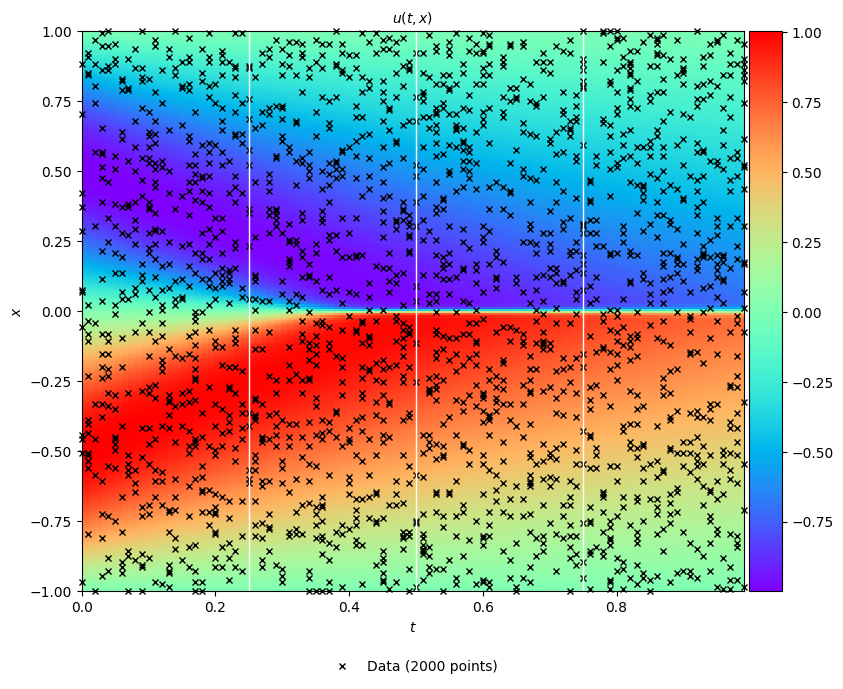

In [10]:
######################################################################
############################# Plotting ###############################
######################################################################
# Assuming your model, X_star, T, and x are already defined and the model is trained

# Reshape your input for prediction
X_star_tensor = torch.tensor(X_star, dtype=torch.float32)
X_pred = X_star_tensor[:, 0:1]
T_pred = X_star_tensor[:, 1:2]

# Get prediction from the model
u_pred_tensor = model.net_u(X_pred, T_pred)
U_pred = u_pred_tensor.detach().cpu().numpy().reshape(T.shape)

# Plotting
fig = plt.figure(figsize=(10, 7))  # You can adjust the figure size as needed

# Row 0: u(t,x)
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.9, bottom=0.1, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Plot the training data on top of the prediction as black crosses
ax.plot(X_u_train[:, 1].detach().cpu().numpy(), X_u_train[:, 0].detach().cpu().numpy(), 'kx', label='Data (%d points)' % (u_train.shape[0]), markersize=4, clip_on=False)

# Add white lines at specific time instances, adjust these indices based on your dataset
times_to_plot = [t[25], t[50], t[75]]  # Replace these with your specific times of interest
for time_instance in times_to_plot:
    ax.plot([time_instance]*2, [x.min(), x.max()], 'w-', linewidth=1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, frameon=False)
ax.set_title('$u(t,x)$', fontsize=10)

plt.show()

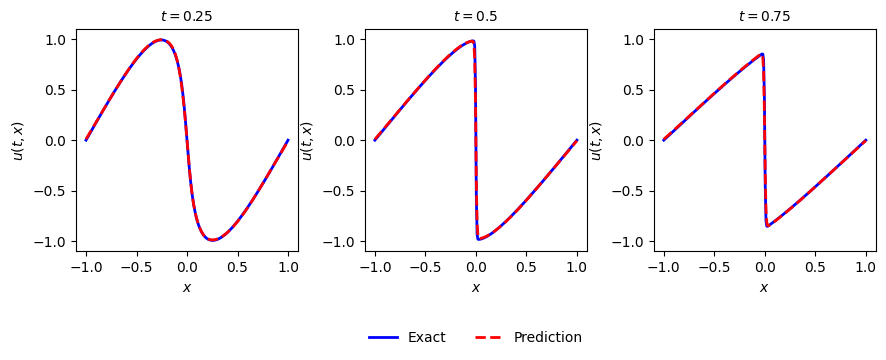

In [11]:
####### Row 1: u(t,x) slices ##################
# Create figure
fig = plt.figure(figsize=(10, 10))  # Adjust the size as needed

# Define the second row grid for u(t,x) slices
gs1 = gridspec.GridSpec(1, 3, top=0.45, bottom=0.1, left=0.1, right=0.9, wspace=0.3)

# Time slices indices, these should correspond to the times you wish to plot
time_indices = [25, 50, 75]

# Plot the exact and predicted slices
for i, time_idx in enumerate(time_indices):
    ax = plt.subplot(gs1[0, i])
    ax.plot(x, Exact[time_idx, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[time_idx, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title(f'$t = {t.flatten()[time_idx]}$', fontsize=10)
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    # Only add the legend to the middle plot for clarity
    if i == 1:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

# Display the plot
plt.show()

NameError: name 'tabular' is not defined

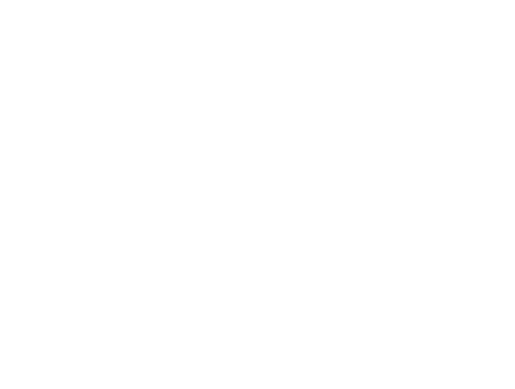

In [34]:
#TODO: bugs here
####### Row 3: Identified PDE ##################
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1.0-2.0/3.0, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')
s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x - 0.0031831 u_{xx} = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1+s2+s3+s4+s5
ax.text(0.1,0.1,s)
savefig('./figures/Burgers_identification')